# Initialize
Importing necessary packages

In [6]:
from pylab import *
import cartopy
import scipy
import numpy
import netCDF4
import numpy as np
import sys
import matplotlib
from matplotlib import colors, ticker
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt
from scipy import stats
from scipy import signal
from scipy.stats.stats import pearsonr

Import data

In [7]:
#data = 'C:/home/Aisawan/Documents/UKMS/cm1out.nc'
dataCQ = '../data/cm1out.nc'

In [8]:
data_set = netCDF4.Dataset(dataCQ, "r")

In [9]:
def get_dates(data_set):
    """Obtain `datetime.datetime` objects from the `'time'` axis of a NetCDF `DataSet`."""
    return netCDF4.num2date(data_set['time'][:], data_set['time'].units)

In [10]:
U = array(data_set.variables['uinterp'])    # radial velocity
V = array(data_set.variables['vinterp'])     # tangential velocity
W = array(data_set.variables['winterp'])    # vertical velocity
prs = array(data_set.variables['prs'])       # pressure (all vertical levels)
surf_prs = array(data_set.variables['sps'])  # surface pressure
rain_fall = array(data_set.variables['rain'])# suface accumulated rainfall
DH = array(data_set.variables['th9'])        # radial grid values
X = array(data_set.variables['ni'])          # radial grid values
Z = array(data_set.variables['nk'])          # vertical grid values
time = array(data_set.variables['time'])     # time

Reshaping data as necessary

In [11]:
# reshape 4-dim variable to 3-dim (t,z,x)
U_T = U.reshape(U.shape[0],U.shape[1],U.shape[3])
V_T = V.reshape(V.shape[0],V.shape[1],V.shape[3])
W_T = W.reshape(W.shape[0],W.shape[1],W.shape[3])
DH_T = DH.reshape(DH.shape[0],DH.shape[1],DH.shape[3])
prs_T = prs.reshape(prs.shape[0],prs.shape[1],prs.shape[3])
# reshape 3-dim to 2-dim
s_prs_T = surf_prs.reshape(surf_prs.shape[0],surf_prs.shape[2])
s_rain = rain_fall.reshape(rain_fall.shape[0],rain_fall.shape[2])

# change pressure to mb (millibars)
prs_mb = prs_T/100
s_prs_mb = s_prs_T/100

# Visualizing data 
Plot one time instance (day 25) of tangential wind profile

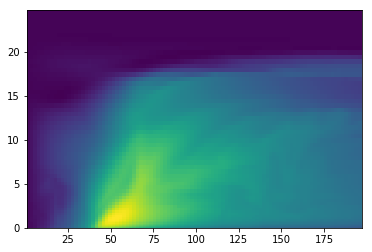

In [43]:
plt.pcolormesh(X[0:99],Z,V_T[100,:,0:99])

Plot minimum pressure and surface rainfall as a function of radius (day 10)

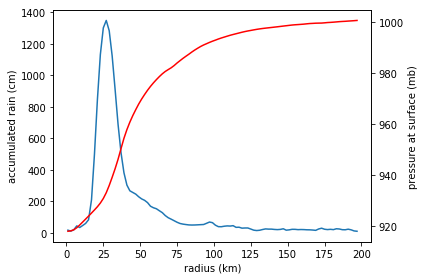

In [13]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('radius (km)')
ax1.set_ylabel('accumulated rain (cm)')
ax1.plot(X[0:99],s_rain[40,0:99])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('pressure at surface (mb)')  # we already handled the x-label with ax1
ax2.plot(X[0:99],prs_mb[40,0,0:99],'r')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

# Extracting variables of interest
minimum tangential velocity (V_T), maximum vertical velocity (W_T), maximum diabatic heating (DH_T), minimum pressure (prs_mb), and minimum radial velocity (U_T)

days 10-120

In [14]:
t_len = 480
t_win = 440

time_test = time[40:t_len]/1440

prs_test = prs_mb[40:t_len,0,0:99]
V_test = V_T[40:t_len,:,0:99]
DH_test = DH_T[40:t_len,:,0:99]
W_test = W_T[40:t_len,:,0:99]
U_test = U_T[40:t_len,:,0:99]

prs_min = np.empty(t_win)
V_max = np.empty(t_win)
DH_max = np.empty(t_win)
W_max = np.empty(t_win)
U_min = np.empty(t_win)

for t in range(t_win):
    prs_min[t] = np.amin(prs_test[t,:])
    V_max[t] = np.amax(V_test[t,:,:])
    DH_max[t] = np.amax(DH_test[t,:,:])
    W_max[t] = np.amax(W_test[t,:,:])
    U_min[t] = np.amin(U_test[t,:,:])

Visualising as timeseries

Minimum surface pressure:

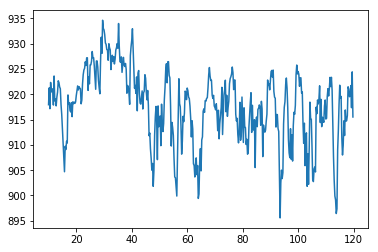

In [15]:
plt.plot(time_test,prs_min)

Maximum tangential wind:

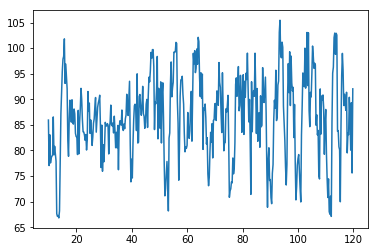

In [16]:
plt.plot(time_test,V_max)

Maximum vertical velocity:

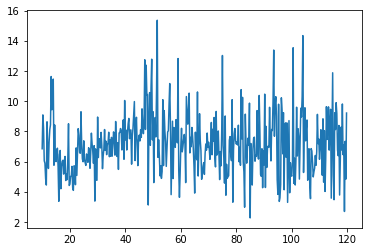

In [17]:
plt.plot(time_test,W_max)

# Calculating correlations between variables of interest
Pearson correlations

In [18]:
VP_cor = stats.pearsonr(V_max,prs_min)
VU_cor = stats.pearsonr(V_max,U_min)
VW_cor = stats.pearsonr(V_max,W_max)
VDH_cor = stats.pearsonr(V_max,DH_max)
PU_cor = stats.pearsonr(prs_min,U_min)
PW_cor = stats.pearsonr(prs_min,W_max)
PDH_cor = stats.pearsonr(prs_min,DH_max)

print('V-Prs correlation = ', VP_cor)
print('V-U correlation = ', VU_cor)
print('V-W correlation = ', VW_cor)
print('V-DH correlation = ', VDH_cor)
print('Prs-U correlation = ', PU_cor)
print('Prs-W correlation = ', PW_cor)
print('Prs-DH correlation = ', PDH_cor)

V-Prs correlation =  (-0.7573749262490744, 4.237764419841814e-83)
V-U correlation =  (-0.9451681566459925, 5.434227007863881e-215)
V-W correlation =  (0.33916895989993984, 2.630285040954164e-13)
V-DH correlation =  (0.2995891437300438, 1.4149642109053766e-10)
Prs-U correlation =  (0.6284198361721139, 9.989555208182039e-50)
Prs-W correlation =  (-0.29050335788750886, 5.273037365182877e-10)
Prs-DH correlation =  (-0.2073463828682022, 1.1614382485337452e-05)


Scatter plot - V$_{max}$ vs. P$_{min}$

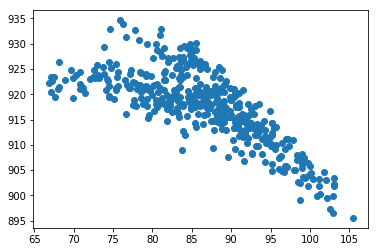

In [19]:
plt.scatter(V_max,prs_min)

Scatter plot - V$_{max}$ vs. U$_{min}$

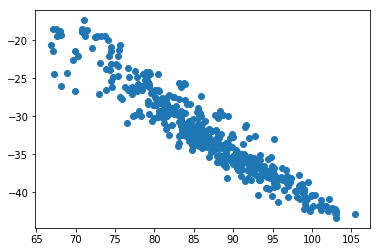

In [20]:
plt.scatter(V_max,U_min)

# Creating a multivariate regression model

In [21]:
from pandas import DataFrame
import pandas as pd

Collect data

In [22]:
d = {'V_max': V_max, 'U_min': U_min, 'W_max': W_max, 'prs_min': prs_min,
     'DH_max': DH_max}
df = pd.DataFrame(d)

In [23]:
df

,V_max,U_min,W_max,prs_min,DH_max
0,85.941147,-27.260708,6.854690,917.935730,0.037780
1,77.052422,-26.204096,9.096639,921.260132,0.045007
2,83.063721,-25.672197,8.190702,917.145691,0.042095
3,77.564087,-29.771513,6.053007,922.335449,0.029320
4,78.535095,-25.993757,5.894318,920.459778,0.029355
5,78.871742,-24.173426,4.860710,921.073364,0.024535
6,79.090950,-24.759785,4.450263,921.042480,0.023754
7,86.551865,-31.983940,8.639151,917.869141,0.047081
8,79.143730,-28.362873,6.953479,923.608521,0.037728
9,80.815605,-27.990435,5.548902,918.677368,0.027427


In [24]:
import statsmodels.formula.api as sm
lm = sm.ols(formula='V_max ~ U_min + W_max + prs_min + DH_max', data=df).fit()
print(lm.params)

Intercept    331.205569
U_min         -1.090720
W_max         -0.205539
prs_min       -0.305288
DH_max        46.335823
dtype: float64


Regression model -
predictand: V$_{max}$, predictors: P$_{min}$, U$_{min}$, W$_{max}$, DH$_{max}$

In [25]:
#create dataframes
y = {'V_max': V_max} 
df_y = pd.DataFrame(y)
x = {'U_min': U_min, 'W_max': W_max, 'prs_min': prs_min, 'DH_max': DH_max}
df_x = pd.DataFrame(x)

In [26]:
import statsmodels.api as sm
df_x = sm.add_constant(df_x) ## let's add an intercept (beta_0) to our model

In [27]:
model = sm.OLS(df_y, df_x).fit() ## sm.OLS(output, input)
predictions = model.predict(df_x)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  V_max   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     1643.
Date:                Thu, 28 Jun 2018   Prob (F-statistic):          5.96e-261
Time:                        14:24:19   Log-Likelihood:                -921.75
No. Observations:                 440   AIC:                             1853.
Df Residuals:                     435   BIC:                             1874.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        331.2056     16.389     20.209      0.000     298.994     363.418
U_min         -1.0907      0.022    -49.009      0.000      -1.134      -1.047
W_max         -0.2055      0.119     -1.729      0.085      -0.439       0.028
prs_min       -0.3053      0.017    -17.571      0.000      -0.339      -0.271
DH_max        46.3358     26.870      1.724      0.085      -6.476      99.147
==============================================================================
Omnibus:                       85.281   Durbin-Watson:                   1.735
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              230.756
Skew:                          -0.933   Prob(JB):                     7.80e-51
Kurtosis:                       6.018   Cond. No.                     2.64e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Regression model -
predictand: V$_{max}$, predictors: P$_{min}$, U$_{min}$

In [28]:
df2_x=pd.DataFrame(df_x, columns=['const','U_min','prs_min'])

In [29]:
model2 = sm.OLS(df_y, df2_x).fit() ## sm.OLS(output, input)
predictions = model2.predict(df2_x)
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  V_max   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     3276.
Date:                Thu, 28 Jun 2018   Prob (F-statistic):          8.67e-264
Time:                        14:24:23   Log-Likelihood:                -923.33
No. Observations:                 440   AIC:                             1853.
Df Residuals:                     437   BIC:                             1865.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        325.9694     16.097     20.250      0.000     294.332     357.606
U_min         -1.0925      0.022    -50.429      0.000      -1.135      -1.050
prs_min       -0.2995      0.017    -17.563      0.000      -0.333      -0.266
==============================================================================
Omnibus:                       80.910   Durbin-Watson:                   1.723
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              213.274
Skew:                          -0.895   Prob(JB):                     4.88e-47
Kurtosis:                       5.903   Cond. No.                     1.57e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Regression model -
predictand: V$_{max}$, predictors: U$_{min}$

In [34]:
df3_x=pd.DataFrame(df_x, columns=['const','U_min'])

In [35]:
model3 = sm.OLS(df_y, df3_x).fit() ## sm.OLS(output, input)
predictions = model3.predict(df3_x)
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  V_max   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     3669.
Date:                Thu, 28 Jun 2018   Prob (F-statistic):          5.43e-215
Time:                        14:26:52   Log-Likelihood:                -1040.8
No. Observations:                 440   AIC:                             2086.
Df Residuals:                     438   BIC:                             2094.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.4333      0.723     60.036      0.000      42.011      44.855
U_min         -1.3316      0.022    -60.569      0.000      -1.375      -1.288
==============================================================================
Omnibus:                        9.075   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               13.226
Skew:                          -0.145   Prob(JB):                      0.00134
Kurtosis:                       3.798   Cond. No.                         194.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Regression model -
predictand: P$_{min}$, predictors: U$_{min}$

In [47]:
df2_y=pd.DataFrame(df_x, columns=['prs_min'])

In [48]:
model4 = sm.OLS(df2_y, df3_x).fit() ## sm.OLS(output, input)
predictions = model4.predict(df3_x)
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                prs_min   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     285.9
Date:                Thu, 28 Jun 2018   Prob (F-statistic):           9.99e-50
Time:                        14:53:35   Log-Likelihood:                -1377.2
No. Observations:                 440   AIC:                             2758.
Df Residuals:                     438   BIC:                             2767.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        943.4385      1.554    607.129      0.000     940.384     946.493
U_min          0.7984      0.047     16.907      0.000       0.706       0.891
==============================================================================
Omnibus:                        5.044   Durbin-Watson:                   0.426
Prob(Omnibus):                  0.080   Jarque-Bera (JB):                4.642
Skew:                           0.193   Prob(JB):                       0.0982
Kurtosis:                       2.678   Cond. No.                         194.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""